In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision


In [2]:
class LinearNoiseScheduler:
    """
    Class for the linear noise scheduler that is used in DDPM.
    """

    def __init__(self, num_timesteps, beta_start, beta_end):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1.0 - self.betas
        self.alpha_cum_prod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_cum_prod = torch.sqrt(self.alpha_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alpha_cum_prod)

    @torch.no_grad()
    def add_noise(self, original, noise, t):
        r"""
        Forward method for diffusion
        :param original: Image on which noise is to be applied
        :param noise: Random Noise Tensor (from normal dist)
        :param t: timestep of the forward process of shape -> (B,)
        :return:
        """
        original_shape = original.shape
        batch_size = original_shape[0]

        sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod.to(original.device)[t].reshape(
            batch_size
        )
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod.to(
            original.device
        )[t].reshape(batch_size)

        # Reshape till (B,) becomes (B,1,1,1) if image is (B,C,H,W)
        sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.view(batch_size, 1, 1, 1)
        sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.view(batch_size, 1, 1, 1)

        # Apply and Return Forward process equation
        return (
            sqrt_alpha_cum_prod.to(original.device) * original
            + sqrt_one_minus_alpha_cum_prod.to(original.device) * noise
        )

    @torch.no_grad()
    def sample_prev_timestep(self, xt, noise_pred, t):
        r"""
            Use the noise prediction by model to get
            xt-1 using xt and the noise predicted
        :param xt: current timestep sample
        :param noise_pred: model noise prediction
        :param t: current timestep we are at
        :return:
        """
        x0 = (
            xt - (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t] * noise_pred)
        ) / torch.sqrt(self.alpha_cum_prod.to(xt.device)[t])
        x0 = torch.clamp(x0, -1.0, 1.0)

        mean = xt - ((self.betas.to(xt.device)[t]) * noise_pred) / (
            self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t]
        )
        mean = mean / torch.sqrt(self.alphas.to(xt.device)[t])

        if t == 0:
            return mean, x0
        else:
            variance = (1 - self.alpha_cum_prod.to(xt.device)[t - 1]) / (
                1.0 - self.alpha_cum_prod.to(xt.device)[t]
            )
            variance = variance * self.betas.to(xt.device)[t]
            sigma = variance**0.5
            z = torch.randn(xt.shape).to(xt.device)

            # OR
            # variance = self.betas[t]
            # sigma = variance ** 0.5
            # z = torch.randn(xt.shape).to(xt.device)
            return mean + sigma * z, x0


In [56]:
linear_scheduler = LinearNoiseScheduler(4000, 1e-4, 1e-2)


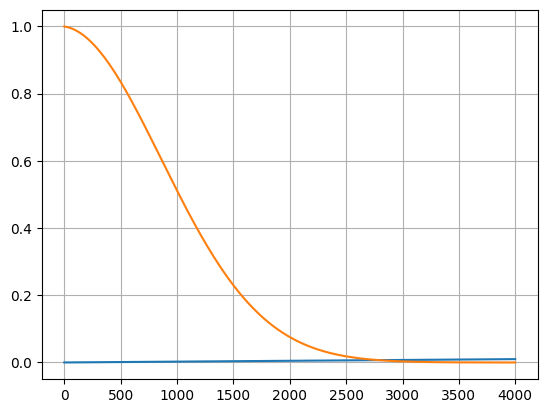

In [57]:
# plot the noise schedule
plt.plot(linear_scheduler.betas)
plt.plot(linear_scheduler.sqrt_alpha_cum_prod)
plt.grid()


tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]]])


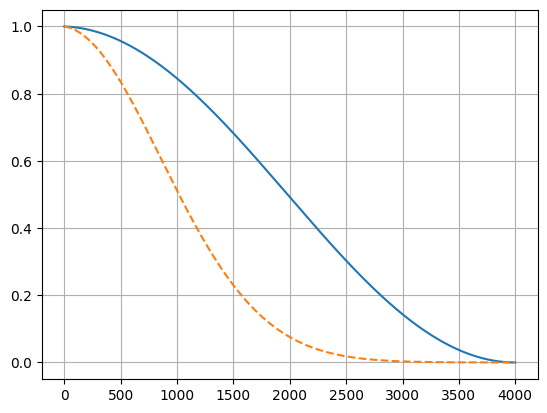

In [97]:
import numpy as np


class CosineNoiseScheduler:
    """
    Class for the cosine noise scheduler used in diffusion models.
    """

    def __init__(self, num_timesteps, beta_start, beta_end):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.s = torch.tensor(beta_start).sqrt() - 1e-8

        # Calculate betas based on the cosine schedule
        timesteps = torch.arange(0, num_timesteps, dtype=torch.float32) / (
            num_timesteps - 1
        )
        f_t = torch.cos(((timesteps + self.s) / (1 + self.s)) * (np.pi / 2)) ** 2

        self.alpha_bar_t = f_t / f_t[0]

    @torch.no_grad()
    def add_noise(self, original, noise, t):
        """
        Forward method for diffusion
        :param original: Image on which noise is to be applied
        :param noise: Random Noise Tensor (from normal distribution)
        :param t: timestep of the forward process of shape -> (B,)
        :return: Noisy image
        """
        original_shape = original.shape
        batch_size = original_shape[0]

        alpha_t_bar = (
            self.alpha_bar_t.to(original.device)[t]
            .reshape(batch_size)
            .view(batch_size, 1, 1, 1)
        )

        return (alpha_t_bar.sqrt() * original) + ((1 - alpha_t_bar).sqrt() * noise)

    @torch.no_grad()
    def sample(self, xt, noise_pred, num_timesteps):
        """Generates samples based off of reduced number of timesteps"""
        t = torch.linspace(0, num_timesteps - 1, num_timesteps).to(xt.device)
        t = (self.num_timesteps - 1) * t / (num_timesteps - 1)
        t = t.long()
        
        for tdx in t:
            beta_seq_t = 1 - (self.alpha_bar_t[tdx] / self.alpha_bar_t[tdx-1])
            
            beta_bar_seq_t = ((1 - self.alpha_bar_t[tdx -1 ]) / (1 - self.alpha_bar_t[tdx])) * beta_seq_t
            
            


cosine_scheduler = CosineNoiseScheduler(4000, 1e-4, 2e-2)
print(cosine_scheduler.sample(torch.randn(1, 3, 256, 256), torch.randn(1, 3, 256, 256), 10))
# plot the noise schedule
plt.plot(cosine_scheduler.alpha_bar_t)
plt.plot(linear_scheduler.sqrt_alpha_cum_prod, linestyle="dashed")
plt.grid()


In [86]:
dataloader = torch.utils.data.DataLoader(
            torchvision.datasets.ImageFolder(
                "data/celeba_hq/val",
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.Resize(512),
                        torchvision.transforms.ToTensor(),
                    ]
                ),
            ),
            batch_size=1,
            shuffle=True,
        )


In [63]:
x, y = next(iter(dataloader))

# Add noise to the image
noise = torch.randn_like(x)
noisy_imgs = []

for t in range(1000):
    x = linear_scheduler.add_noise(x, noise, torch.tensor([t]))

    noisy_imgs.append(x)


In [64]:
noisy_imgs = torch.cat(noisy_imgs, dim=0)
plt.figure(figsize=(200, 200))
grid = torchvision.utils.make_grid(noisy_imgs, nrow=50)
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")


KeyboardInterrupt: 

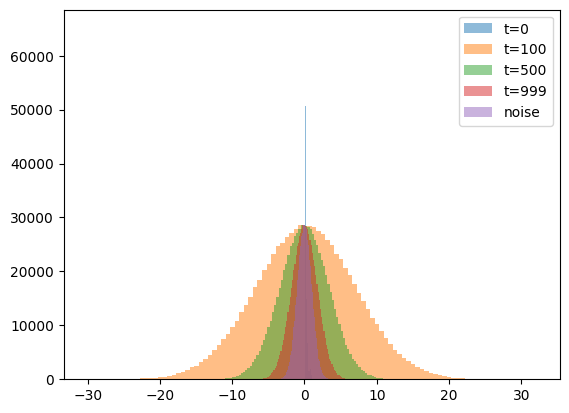

In [65]:
plt.hist(noisy_imgs[0].flatten().cpu().numpy(), bins=100, label="t=0", alpha=0.5)
plt.hist(noisy_imgs[100].flatten().cpu().numpy(), bins=100, label="t=100", alpha=0.5)
plt.hist(noisy_imgs[500].flatten().cpu().numpy(), bins=100, label="t=500", alpha=0.5)
plt.hist(noisy_imgs[999].flatten().cpu().numpy(), bins=100, label="t=999", alpha=0.5)
plt.hist(noise.flatten().cpu().numpy(), bins=100, label="noise", alpha=0.5)
plt.legend()
plt.show()
